In [1]:
# Momentum Balance Diagnostics from MITgcm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
Qsg = 700
hs = 12
File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/UmomDiag_' + str(format(hs,'03d')) + '.nc')
File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/SrfDiag_' + str(format(hs,'03d')) + '.nc')
File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
File4 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')


T0 = 275 # or 81/275 for one/two week run
Tn = len(File1.T)
UmomDiag = File1.isel(Xp1=range(121), Y=range(30,39), T=range(T0-1,Tn))
SrfDiag = File2.isel(X=range(120), Y=range(30,39), T=range(T0-1,Tn))
Grid = File3.isel(X=range(120), Xp1=range(121), Y=range(30,39))
State = File4.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(T0,Tn))


Ut = UmomDiag.TOTUTEND.data #Tendency of Zonal Component of Velocity (m/s/day) T*Zmd*Y*Xp1
Udis = UmomDiag.Um_Diss.data.mean(axis=(0,2)) # U momentum tendency from Dissipation (m/s^2) T*Zmd*Y*Xp1
Uadv = UmomDiag.Um_Advec.data.mean(axis=(0,2)) # U momentum tendency from Advection terms (m/s^2) T*Zmd*Y*Xp1
#Uext = UmomDiag.Um_Ext.data # U momentum from External Forcing (m/s^2) T*Zmd*Y*Xp1
Uph = UmomDiag.Um_dPHdx.data.mean(axis=(0,2)) # U momentum from Hydrostatic Pressure grad (m/s^2) T*Zmd*Y*Xp1
#Uab = UmomDiag.AB_gU.data # U momentum from Adam-Bashforth (m/s^2) T*Zmd*Y*Xp1
Ucori = UmomDiag.Um_Cori.data.mean(axis=(0,2)) # U momentum tendency from Coriolis term (m/s^2) T*Zmd*Y*Xp1
#UvisrI = UmomDiag.VISrI_Um.data # Vertical Viscous Flux of U momentum (Implicit part) (m^4/s^2)  T*Zld*Y*Xp1
Uimp = UmomDiag.Um_ImplD.data.mean(axis=(0,2)) # U momentum tendency from Dissipation (Implicit part) (m/s^2) T*Zmd*Y*Xp1
#SidDrag = UmomDiag.USidDrag.data # U momentum tendency from Bottom Drag (m/s^2) T*Zmd*Y*Xp1
BotDrag = UmomDiag.UBotDrag.data.mean(axis=(0,2)) # U momentum tendency from Side Drag (m/s^2) T*Zmd*Y*Xp1

Etan = SrfDiag.ETAN.data.mean(axis=(0,2)) # Surface Height Anomaly (m) T*1*Y*X

dxC = Grid.dxC.data # x cell center separation (Y*Xp1)
x = Grid.X.data # X-Coordinate of cell corner
z = Grid.Z.data # vertical coordinate of cell center

pg_srf = -9.81 * np.diff(Etan, axis=-1, prepend=0) / dxC[4,1:]
Barotropic = np.repeat(pg_srf, 50, axis=0) # Pressure gradient term from surface elevation

s = State.S.data.mean(axis=(0,2)) # Salinity
U0 = State.U.data.mean(axis=(0,2)) # Along-channel velocity
u = (U0[:, 1:] + U0[:, :-1]) / 2
mask = (s == 0) # Exclude data covered by the sill
s[mask] = np.nan
u[mask] = np.nan

In [3]:
def Layer(U, X, Z):
    H1 = np.empty(len(X)-2)
    depth = Z
    for i in range(1,len(X)-1):
        l = np.where(U[:, i] < 0)[-1][0] - 1
        #z_th[i-1] =  w[l, i] * pt[l, i]
        #h1[i-1] = -depth[l]
        # Calculate layer depth
        if l <= 9:
            H1[i-1] = -depth[l]+0.25
        elif l <= 19:
            H1[i-1] = -depth[l]+0.5
        elif l <= 29:
            H1[i-1] = -depth[l]+0.75
        elif l <= 39:
            H1[i-1] = -depth[l]+2
        elif l <= 49:
            H1[i-1] = -depth[l]+4
    
    return (H1)

In [4]:
h1 = Layer(u, x, z)

Cori = (Ucori[:, 1:] + Ucori[:, :-1]) / 2
Adv = (Uadv[:, 1:] + Uadv[:, :-1]) / 2 - Cori
#Dis = (Udis[:, 1:] + Udis[:, :-1]) / 2

Bot = (BotDrag[:, 1:] + BotDrag[:, :-1]) / 2

Vis = (Udis[:, 1:] + Udis[:, :-1]) / 2 + (Uimp[:, 1:] + Uimp[:, :-1]) / 2 - Bot


Pgf = (Uph[:, 1:] + Uph[:, :-1]) / 2 + Barotropic


Adv[mask] = np.nan
Vis[mask] = np.nan
Bot[mask] = np.nan
#Cori[mask] = np.nan
Pgf[mask] = np.nan


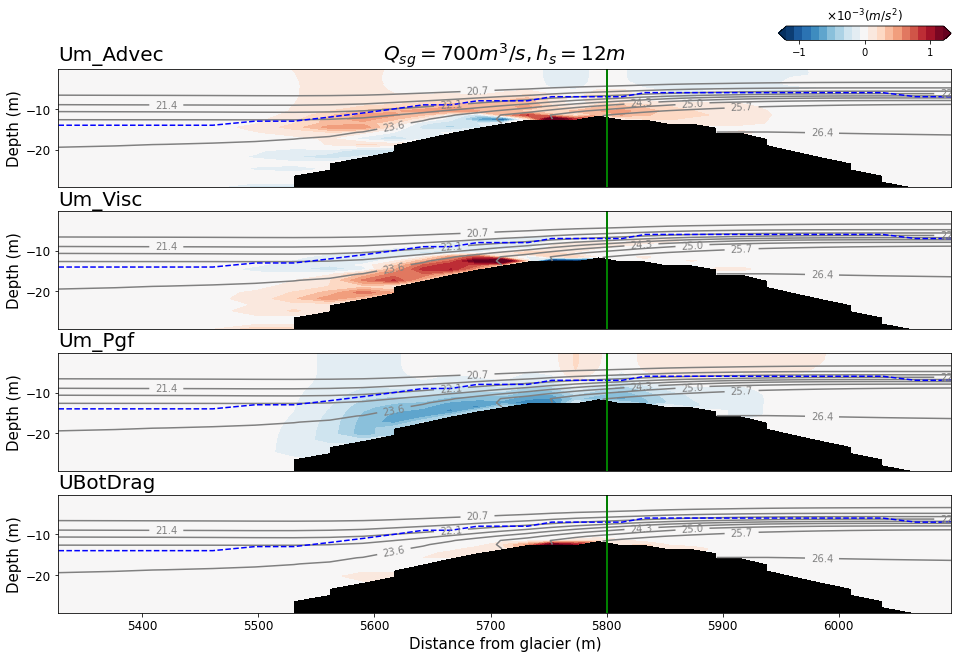

In [5]:
fig1 = plt.figure(figsize=(16,10))
fig1.tight_layout()

cm = np.linspace(-1.2,1.2,20) # Contour range for momentum terms
cs = np.linspace(20,30,15)
cmap = 'RdBu_r'

Xl, Xr = 55, 85 # X range
Zu, Zl = 0, 30 # Z range

# Advective Term Plot
ax1 = fig1.add_subplot(411)
im1 = ax1.contourf(x[Xl:Xr], z[Zu:Zl], Adv[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap, extend='both')
ax1.plot(x[Xl:Xr],-h1[Xl:Xr], '--b')
ax1.xaxis.set_visible(False)
ax1.set_xlim([x[Xl], x[Xr-1]])
ax1.set_facecolor('k')

cbaxes = fig1.add_axes([0.75, 0.92, 0.15, 0.02])
cbar = fig1.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([-2, -1, 0, 1, 2])
cbar.ax.set_title(r'$\times10^{-3}(m/s^2)$', size=12, weight='bold')
# Plot isohalines
CS1 = ax1.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS1, fmt='%1.1f', fontsize=10, inline=1)
ax1.axvline(x=5800, color='g',lw=2)
#ax1.axhline(y=-11.5, color='r',lw=2)
ax1.set_ylabel('Depth (m)', size=15)
ax1.tick_params(labelsize=12)
ax1.set_title(r'Um_Advec', loc='left', size=20)
ax1.set_title(r'$Q_{sg}=$'+str(Qsg)+r'$m^3/s,h_s=$'+str(hs)+'$m$', loc='center', size=20)



# Viscous Term Plot
ax2 = fig1.add_subplot(412)
im2 = ax2.contourf(x[Xl:Xr], z[Zu:Zl], Vis[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap, extend='both')
ax2.plot(x[Xl:Xr],-h1[Xl:Xr], '--b')
ax2.xaxis.set_visible(False)
ax2.set_xlim([x[Xl], x[Xr-1]])
ax2.set_facecolor('k')
# Plot isohalines
CS2 = ax2.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS2, fmt='%1.1f', fontsize=10, inline=1)
ax2.axvline(x=5800, color='g',lw=2)
ax2.set_ylabel('Depth (m)', size=15)
ax2.tick_params(labelsize=12)
ax2.set_title(r'Um_Visc', loc='left', size=20)

# Pressure gradient term Plot
ax3 = fig1.add_subplot(413)
im3 = ax3.contourf(x[Xl:Xr], z[Zu:Zl], Pgf[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap, extend='both')
ax3.plot(x[Xl:Xr],-h1[Xl:Xr], '--b')
ax3.set_xlim([x[Xl], x[Xr-1]])
ax3.set_facecolor('k')
# Plot isohalines
CS3 = ax3.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS3, fmt='%1.1f', fontsize=10, inline=1)
ax3.axvline(x=5800, color='g',lw=2)
ax3.set_ylabel('Depth (m)', size=15)
ax3.tick_params(labelsize=12)
ax3.set_title(r'Um_Pgf', loc='left', size=20)
ax3.xaxis.set_visible(False)
ax3.tick_params(labelsize=12)


# Bottom Drag Plot
ax4 = fig1.add_subplot(414)
im4 = ax4.contourf(x[Xl:Xr], z[Zu:Zl], Bot[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap, extend='both')
ax4.plot(x[Xl:Xr],-h1[Xl:Xr], '--b')
ax4.set_xlim([x[Xl], x[Xr-1]])
ax4.set_facecolor('k')
# Plot isohalines
CS4 = ax4.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS4, fmt='%1.1f', fontsize=10, inline=1)
ax4.axvline(x=5800, color='g',lw=2)
ax4.set_ylabel('Depth (m)', size=15)
ax4.tick_params(labelsize=12)
ax4.set_title(r'UBotDrag', loc='left', size=20)
ax4.set_xlabel('Distance from glacier (m)', size=15)
ax4.tick_params(labelsize=12)

In [6]:
def AF_Momentum(Qsg, hs):
    
    File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/UmomDiag_' + str(format(hs,'03d')) + '.nc')
    File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/SrfDiag_' + str(format(hs,'03d')) + '.nc')
    File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
    File4 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')


    T0 = 275 # or 81/275 for one/two week run
    Tn = len(File1.T)
    UmomDiag = File1.isel(Xp1=range(121), Y=range(30,39), T=range(T0-1,Tn))
    SrfDiag = File2.isel(X=range(120), Y=range(30,39), T=range(T0-1,Tn))
    Grid = File3.isel(X=range(120), Xp1=range(121), Y=range(30,39))
    State = File4.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(T0,Tn))

    U = State.U.data.mean(axis=(0,2))
    u = (U[:, 1:] + U[:, :-1]) / 2
    s = State.S.data.mean(axis=(0,2)) # Salinity
    x = Grid.X.data
    z = Grid.Z.data
    dxC = Grid.dxC.data # x cell center separation (Y*Xp1)

    mask = (s == 0) # Exclude data covered by the sill
    s[mask] = np.nan
    u[mask] = np.nan
    
    Udis = UmomDiag.Um_Diss.data.mean(axis=(0,2)) # U momentum tendency from Dissipation (m/s^2) T*Zmd*Y*Xp1
    Uadv = UmomDiag.Um_Advec.data.mean(axis=(0,2)) # U momentum tendency from Advection terms (m/s^2) T*Zmd*Y*Xp1
    Uph = UmomDiag.Um_dPHdx.data.mean(axis=(0,2)) # U momentum from Hydrostatic Pressure grad (m/s^2) T*Zmd*Y*Xp1
    Ucori = UmomDiag.Um_Cori.data.mean(axis=(0,2)) # U momentum tendency from Coriolis term (m/s^2) T*Zmd*Y*Xp1
    Uimp = UmomDiag.Um_ImplD.data.mean(axis=(0,2)) # U momentum tendency from Dissipation (Implicit part) (m/s^2) T*Zmd*Y*Xp1
    BotDrag = UmomDiag.UBotDrag.data.mean(axis=(0,2)) # U momentum tendency from Side Drag (m/s^2) T*Zmd*Y*Xp1

    Etan = SrfDiag.ETAN.data.mean(axis=(0,2)) # Surface Height Anomaly (m) T*1*Y*X
    pg_srf = -9.81 * np.diff(Etan, axis=-1, prepend=0) / dxC[4,1:]
    Barotropic = np.repeat(pg_srf, 50, axis=0) # Pressure gradient term from surface elevation
    
    Cori = (Ucori[:, 1:] + Ucori[:, :-1]) / 2
    Adv = (Uadv[:, 1:] + Uadv[:, :-1]) / 2 - Cori
    #Dis = (Udis[:, 1:] + Udis[:, :-1]) / 2
    
    Bot = (BotDrag[:, 1:] + BotDrag[:, :-1]) / 2

    Vis = (Udis[:, 1:] + Udis[:, :-1]) / 2 + (Uimp[:, 1:] + Uimp[:, :-1]) / 2 - Bot

    Pgf = (Uph[:, 1:] + Uph[:, :-1]) / 2 + Barotropic
    
    Adv[mask] = np.nan
    Bot[mask] = np.nan
    Vis[mask] = np.nan
    Pgf[mask] = np.nan
    
    return (Adv, Vis, Pgf, Bot, u)

In [7]:
def Layer_Int(Input, X1, X2, U):
    I = np.empty(X2-X1+1)
    Int_x = np.empty(X2-X1+1)
    for i in range(len(I)):
        L = np.where(U[:, X1+i] < 0)[-1][0] - 1
        Int_x[i] = Input[L, X1+i]
        
    return (Int_x.mean())


In [8]:
sd = np.array([9, 12, 15, 18, 30])
Qf = 700
X0, Xs = 55, 72 # X range for the sill slope

ADV = np.empty(len(sd))
VIS = np.empty(len(sd))
PGF = np.empty(len(sd))
FRI = np.empty(len(sd))
#D = np.array([9, 11, 12 ,14, 20])
for i in range(len(sd)):
    adv, visc, pgf, bot, ux = AF_Momentum(Qf, sd[i])
    #ADVh[i] = np.nanmean(advh[19, X0:Xs])
    #ADVv[i] = np.nanmean(advv[19, X0:Xs])
    #Vis[i] = np.nanmean(visc[19, X0:Xs])
    ADV[i] = Layer_Int(adv, X0, Xs, ux)
    VIS[i] = Layer_Int(visc, X0, Xs, ux)
    PGF[i] = Layer_Int(pgf, X0, Xs, ux)
    FRI[i] = Layer_Int(bot, X0, Xs, ux)


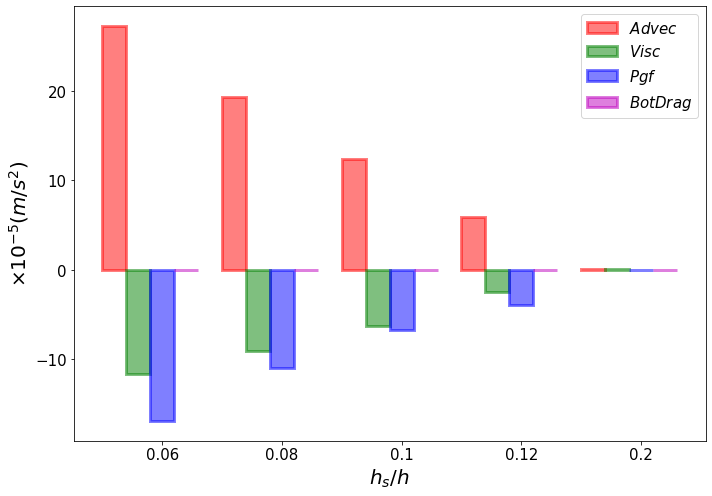

In [11]:

#labels = [r'$h_s=9m$', r'$h_s=12m$', r'$h_s=15m$', r'$h_s=18m$', r'$h_s=30m$']
labels = sd / 150

N = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars


fig2, ax = plt.subplots(figsize=(10,7))

ax.bar(N - 2*width,ADV*1e5, width, label=r'$Advec$', facecolor='r', edgecolor='r', linewidth=3, alpha=.5)
ax.bar(N - width, VIS*1e5, width, label=r'$Visc$', facecolor='g', edgecolor='g', linewidth=3, alpha=.5)
ax.bar(N , PGF*1e5, width, label=r'$Pgf$', facecolor='b', edgecolor='b', linewidth=3, alpha=.5)
ax.bar(N + width, FRI*1e5, width, label=r'$BotDrag$', facecolor='m', edgecolor='m', linewidth=3, alpha=.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\times10^{-5}(m/s^2)$', fontsize=20)
#ax.set_title('Scores by group and gender')
ax.set_xticks(N)
ax.set_xlabel(r'$h_s/h$', fontsize=20)
ax.set_xticklabels(labels, fontsize=20)
ax.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig2.tight_layout()